In [1]:
# %% [markdown]
# # Data Exploration - ripenessVision
# 
# EDA dan analisis data gambar buah

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import json
from collections import Counter

In [2]:
# %%
# Setup
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data' / 'raw'
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

In [3]:
# %%
# Load metadata
train_df = pd.read_csv(PROCESSED_DIR / 'train_metadata.csv')
val_df = pd.read_csv(PROCESSED_DIR / 'val_metadata.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'test_metadata.csv')

with open(PROCESSED_DIR / 'data_splits.json', 'r') as f:
    split_info = json.load(f)

In [4]:
# %%
# Combine all data for exploration
df = pd.concat([train_df, val_df, test_df])
print(f"Total dataset size: {len(df)}")

Total dataset size: 794


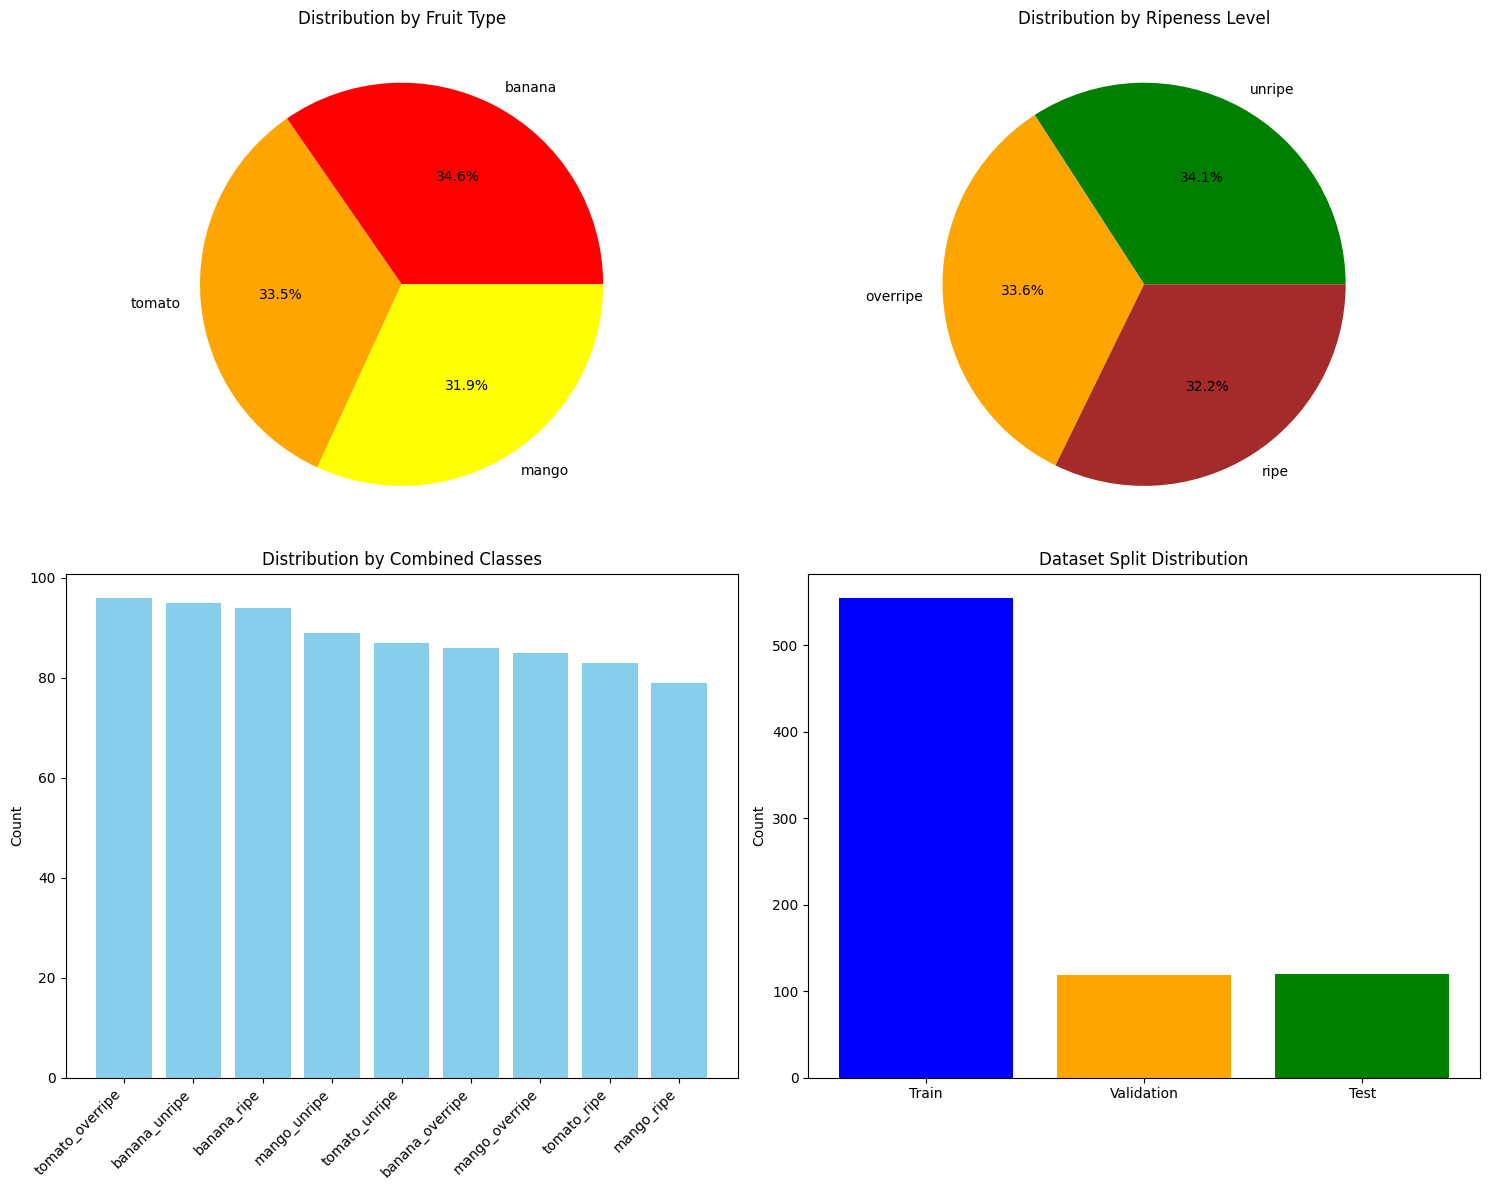

In [5]:
# %%
# Detailed distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Fruit distribution
fruit_counts = df['fruit'].value_counts()
axes[0, 0].pie(fruit_counts.values, labels=fruit_counts.index, autopct='%1.1f%%',
               colors=['red', 'orange', 'yellow'])
axes[0, 0].set_title('Distribution by Fruit Type')

# Ripeness distribution
ripeness_counts = df['ripeness'].value_counts()
axes[0, 1].pie(ripeness_counts.values, labels=ripeness_counts.index, autopct='%1.1f%%',
               colors=['green', 'orange', 'brown'])
axes[0, 1].set_title('Distribution by Ripeness Level')

# Combined class distribution
class_counts = df['class'].value_counts()
axes[1, 0].bar(range(len(class_counts)), class_counts.values, color='skyblue')
axes[1, 0].set_xticks(range(len(class_counts)))
axes[1, 0].set_xticklabels(class_counts.index, rotation=45, ha='right')
axes[1, 0].set_title('Distribution by Combined Classes')
axes[1, 0].set_ylabel('Count')

# Split distribution
split_counts = pd.Series({
    'Train': len(train_df),
    'Validation': len(val_df),
    'Test': len(test_df)
})
axes[1, 1].bar(split_counts.index, split_counts.values, color=['blue', 'orange', 'green'])
axes[1, 1].set_title('Dataset Split Distribution')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Cross-tabulation of Fruit vs Ripeness:
ripeness  overripe  ripe  unripe
fruit                           
banana          86    94      95
mango           85    79      89
tomato          96    83      87


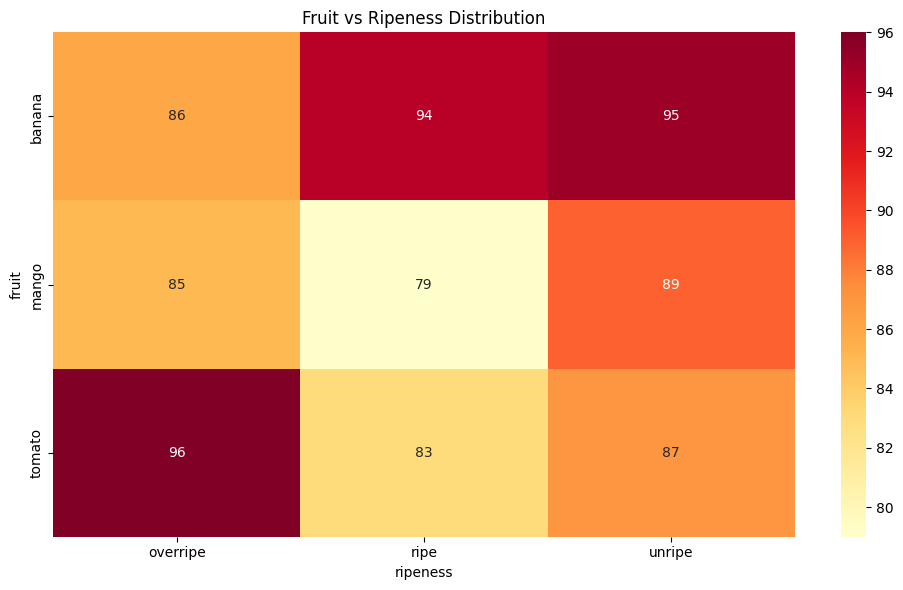

In [6]:
# %%
# Cross-tabulation of fruit and ripeness
cross_tab = pd.crosstab(df['fruit'], df['ripeness'])
print("Cross-tabulation of Fruit vs Ripeness:")
print(cross_tab)

plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Fruit vs Ripeness Distribution')
plt.tight_layout()
plt.show()

In [7]:
# %%
# Image size analysis
def get_image_stats(file_paths):
    widths, heights = [], []
    for file_path in file_paths:
        try:
            with Image.open(file_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except:
            continue
    return widths, heights


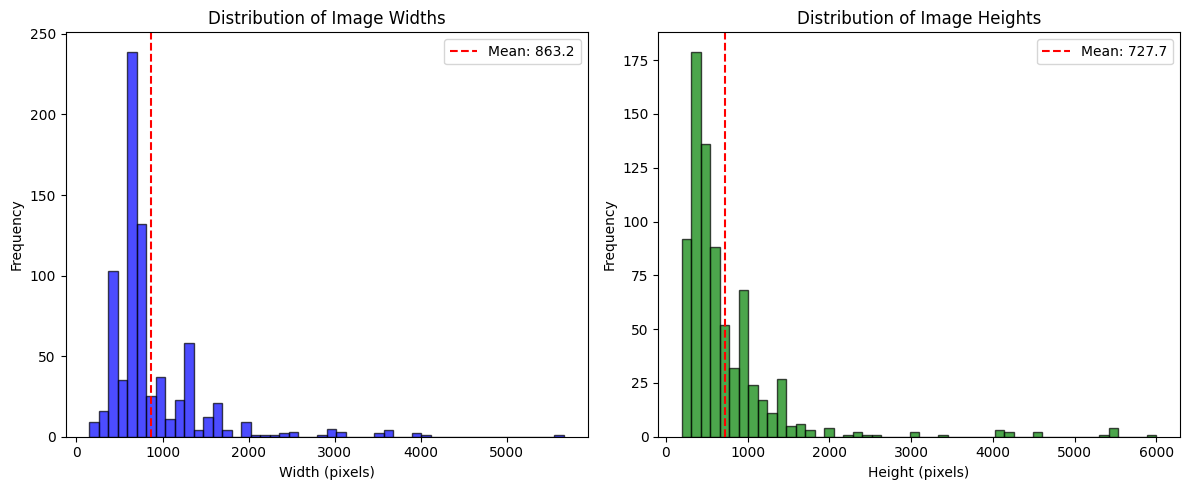

Image dimensions - Width: 863.2 ± 573.2
Image dimensions - Height: 727.7 ± 673.1


In [8]:
# %%
# Analyze image dimensions
widths, heights = get_image_stats(df['file_path'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(widths, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Image Widths')
axes[0].axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.1f}')
axes[0].legend()

axes[1].hist(heights, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Image Heights')
axes[1].axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Image dimensions - Width: {np.mean(widths):.1f} ± {np.std(widths):.1f}")
print(f"Image dimensions - Height: {np.mean(heights):.1f} ± {np.std(heights):.1f}")

In [9]:
# %%
# Color analysis
def analyze_colors(file_paths, sample_size=100):
    if len(file_paths) > sample_size:
        file_paths = np.random.choice(file_paths, sample_size, replace=False)
    
    hsv_values = []
    for file_path in file_paths:
        try:
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            hsv_values.extend(img.reshape(-1, 3))
        except:
            continue
    
    return np.array(hsv_values)


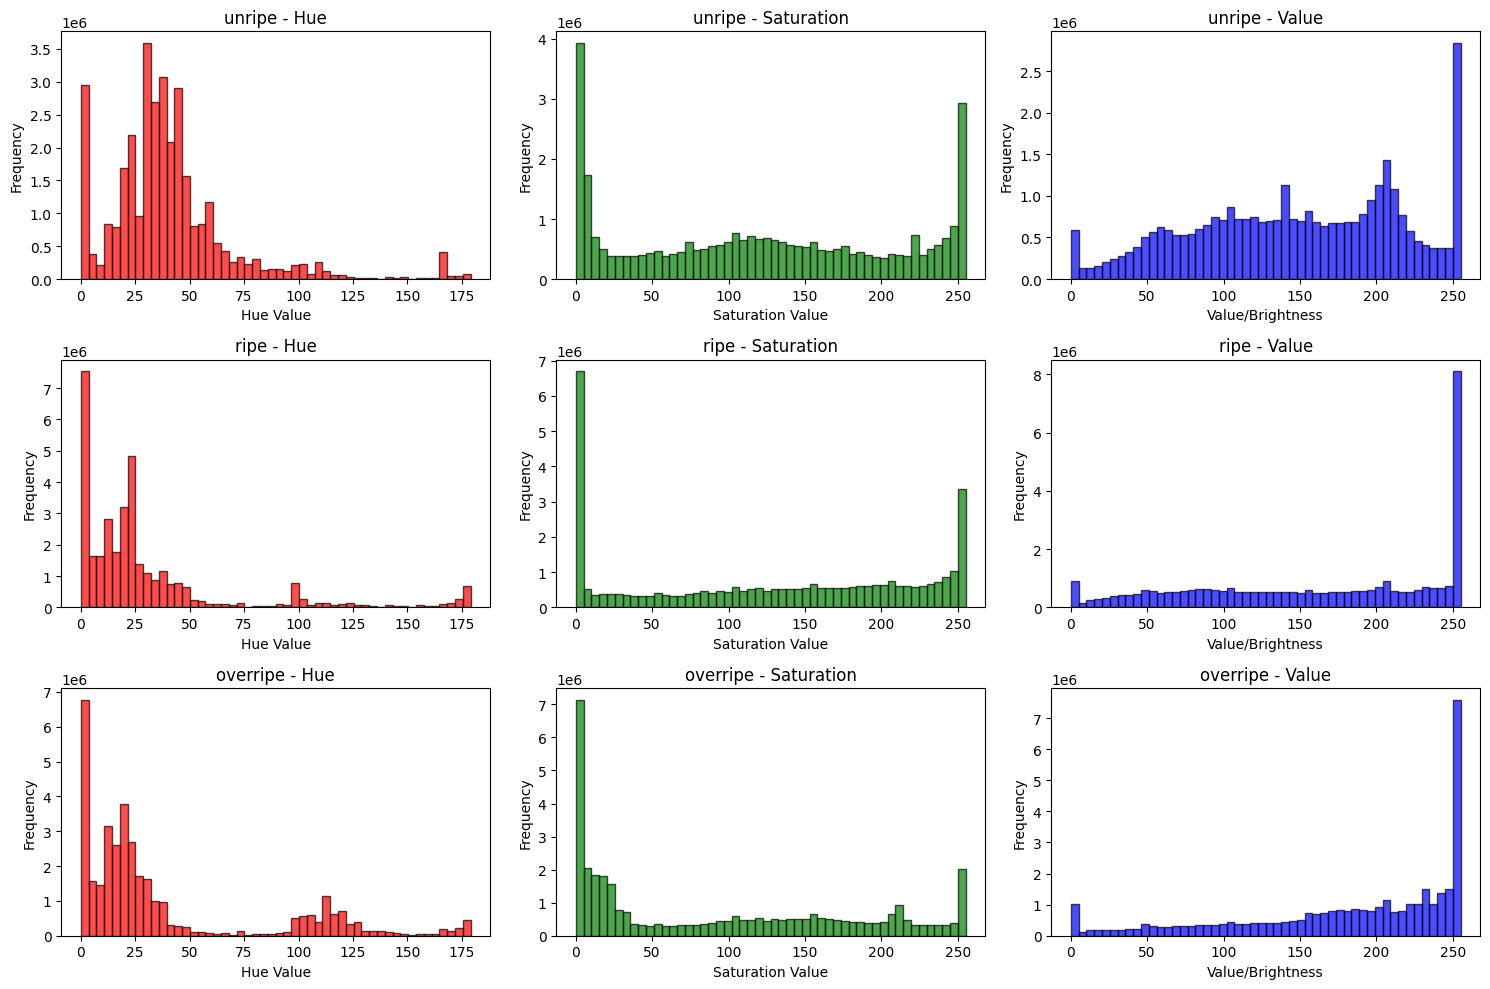

In [10]:
# %%
# Color analysis for different ripeness levels
plt.figure(figsize=(15, 10))

for i, ripeness in enumerate(['unripe', 'ripe', 'overripe']):
    ripeness_files = df[df['ripeness'] == ripeness]['file_path'].tolist()
    if len(ripeness_files) > 0:
        hsv_values = analyze_colors(ripeness_files, 50)
        
        if len(hsv_values) > 0:
            plt.subplot(3, 3, i*3 + 1)
            plt.hist(hsv_values[:, 0], bins=50, alpha=0.7, color='red', edgecolor='black')
            plt.title(f'{ripeness} - Hue')
            plt.xlabel('Hue Value')
            plt.ylabel('Frequency')
            
            plt.subplot(3, 3, i*3 + 2)
            plt.hist(hsv_values[:, 1], bins=50, alpha=0.7, color='green', edgecolor='black')
            plt.title(f'{ripeness} - Saturation')
            plt.xlabel('Saturation Value')
            plt.ylabel('Frequency')
            
            plt.subplot(3, 3, i*3 + 3)
            plt.hist(hsv_values[:, 2], bins=50, alpha=0.7, color='blue', edgecolor='black')
            plt.title(f'{ripeness} - Value')
            plt.xlabel('Value/Brightness')
            plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


UnidentifiedImageError: cannot identify image file '..\\data\\raw\\banana\\unripe\\unripe_banana_high_quality_photo_98.jpg'

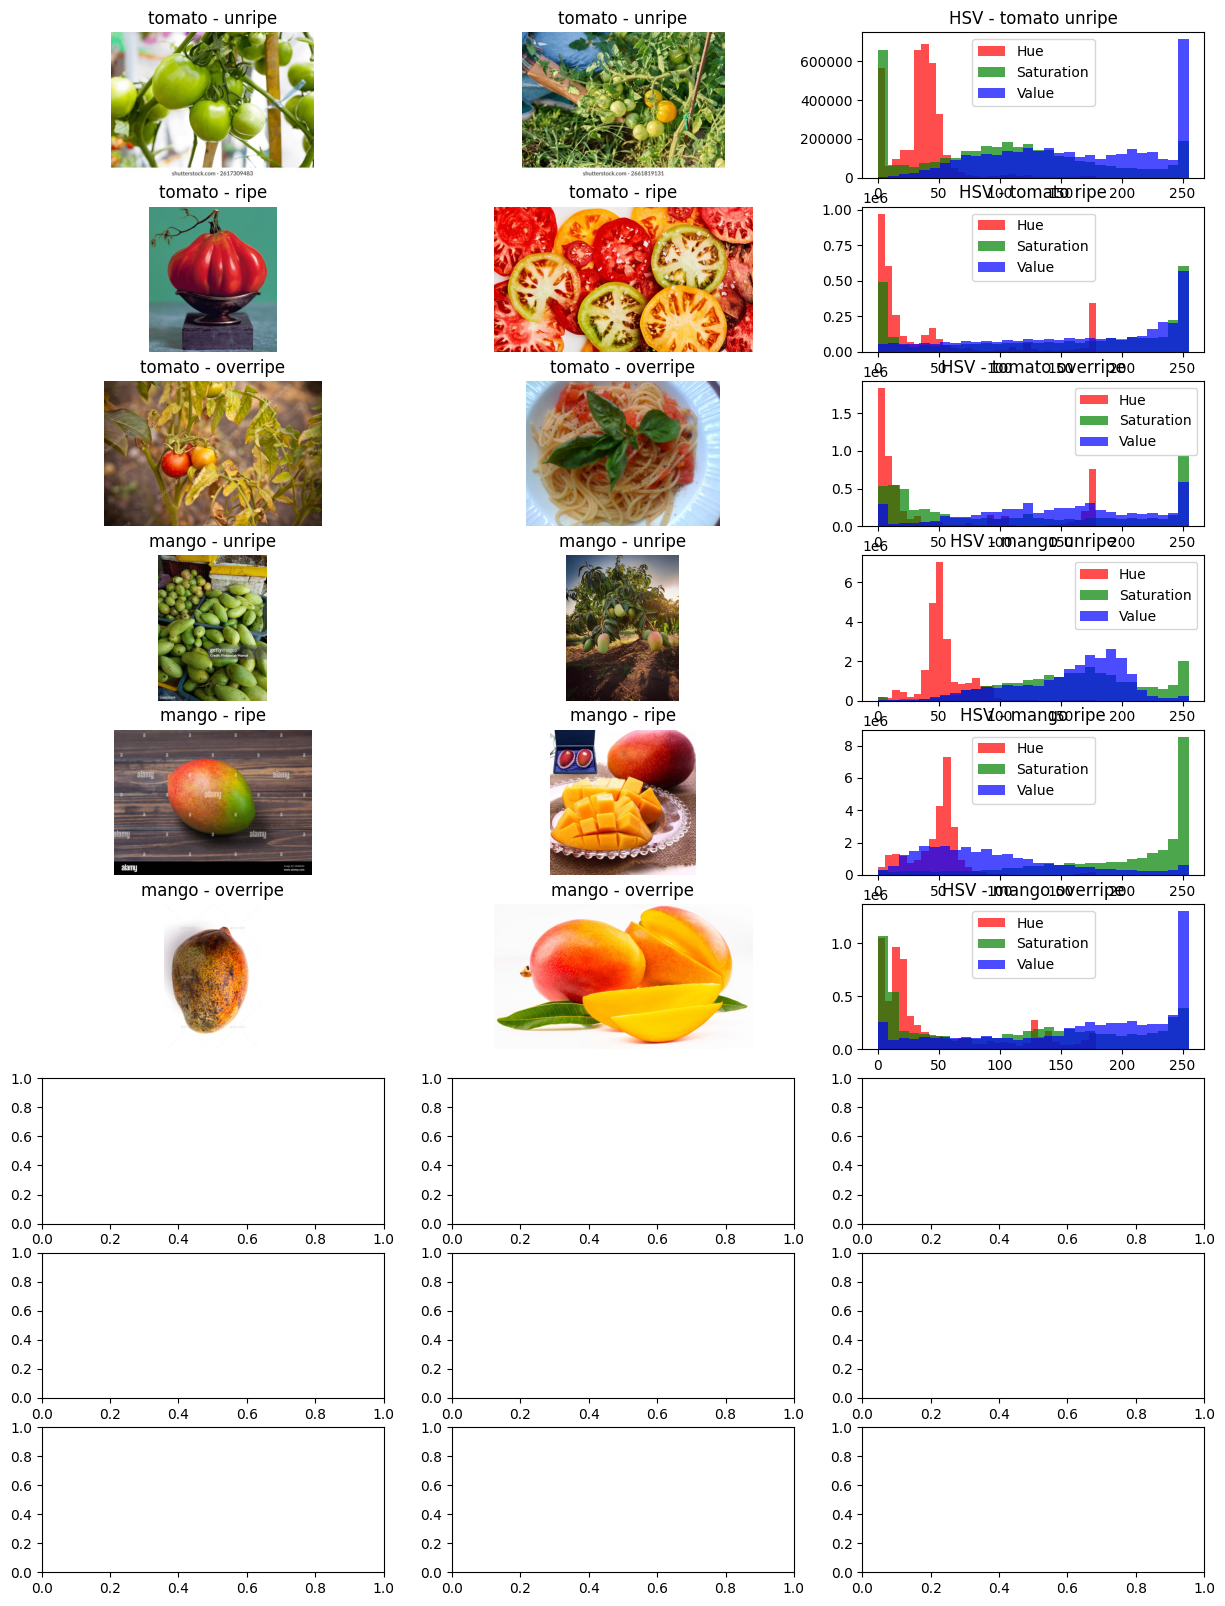

In [11]:
# %%
# Sample images with color analysis
def display_images_with_hsv(df, samples_per_class=2):
    fig, axes = plt.subplots(9, samples_per_class + 1, figsize=(15, 20))
    
    for i, fruit in enumerate(['tomato', 'mango', 'banana']):
        for j, ripeness in enumerate(['unripe', 'ripe', 'overripe']):
            class_df = df[(df['fruit'] == fruit) & (df['ripeness'] == ripeness)]
            
            if len(class_df) > 0:
                # Show original images
                for k in range(samples_per_class):
                    if k < len(class_df):
                        sample = class_df.iloc[k]
                        img = Image.open(sample['file_path'])
                        axes[i*3 + j, k].imshow(img)
                        axes[i*3 + j, k].set_title(f"{fruit} - {ripeness}")
                        axes[i*3 + j, k].axis('off')
                
                # Show HSV histogram for the class
                if len(class_df) > 0:
                    hsv_values = analyze_colors(class_df['file_path'].tolist(), 10)
                    if len(hsv_values) > 0:
                        axes[i*3 + j, samples_per_class].hist(hsv_values[:, 0], bins=30, 
                                                             alpha=0.7, color='red', label='Hue')
                        axes[i*3 + j, samples_per_class].hist(hsv_values[:, 1], bins=30, 
                                                             alpha=0.7, color='green', label='Saturation')
                        axes[i*3 + j, samples_per_class].hist(hsv_values[:, 2], bins=30, 
                                                             alpha=0.7, color='blue', label='Value')
                        axes[i*3 + j, samples_per_class].set_title(f'HSV - {fruit} {ripeness}')
                        axes[i*3 + j, samples_per_class].legend()
    
    plt.tight_layout()
    plt.show()

display_images_with_hsv(df)

In [12]:
# %%
# Data quality check
def check_data_quality(file_paths):
    issues = []
    for file_path in file_paths:
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify integrity
        except Exception as e:
            issues.append((file_path, str(e)))
    return issues


In [13]:
# %%
# Check for corrupted images
print("Checking for corrupted images...")
issues = check_data_quality(df['file_path'])
if issues:
    print(f"Found {len(issues)} corrupted images:")
    for issue in issues[:5]:  # Show first 5 issues
        print(f"  {issue[0]}: {issue[1]}")
else:
    print("No corrupted images found!")


Checking for corrupted images...
Found 29 corrupted images:
  ..\data\raw\banana\unripe\unripe_banana_high_quality_photo_98.jpg: cannot identify image file '..\\data\\raw\\banana\\unripe\\unripe_banana_high_quality_photo_98.jpg'
  ..\data\raw\mango\overripe\overripe_mango_high_quality_photo_25.jpg: cannot identify image file '..\\data\\raw\\mango\\overripe\\overripe_mango_high_quality_photo_25.jpg'
  ..\data\raw\mango\unripe\unripe_mango_high_quality_photo_46.jpg: cannot identify image file '..\\data\\raw\\mango\\unripe\\unripe_mango_high_quality_photo_46.jpg'
  ..\data\raw\banana\overripe\overripe_banana_high_quality_photo_38.jpg: cannot identify image file '..\\data\\raw\\banana\\overripe\\overripe_banana_high_quality_photo_38.jpg'
  ..\data\raw\banana\overripe\overripe_banana_high_quality_photo_45.jpg: cannot identify image file '..\\data\\raw\\banana\\overripe\\overripe_banana_high_quality_photo_45.jpg'


In [14]:
# %%
# Summary statistics
print("\n=== DATASET SUMMARY ===")
print(f"Total images: {len(df)}")
print(f"Number of classes: {len(df['class'].unique())}")
print(f"Fruit types: {df['fruit'].unique().tolist()}")
print(f"Ripeness levels: {df['ripeness'].unique().tolist()}")
print(f"Average image size: {np.mean(widths):.0f}x{np.mean(heights):.0f}")
print(f"Dataset splits - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


=== DATASET SUMMARY ===
Total images: 794
Number of classes: 9
Fruit types: ['banana', 'tomato', 'mango']
Ripeness levels: ['unripe', 'ripe', 'overripe']
Average image size: 863x728
Dataset splits - Train: 555, Val: 119, Test: 120


In [15]:
# %%
# Save exploration results
exploration_results = {
    'total_images': len(df),
    'class_distribution': df['class'].value_counts().to_dict(),
    'average_width': np.mean(widths),
    'average_height': np.mean(heights),
    'corrupted_images': len(issues),
    'split_distribution': {
        'train': len(train_df),
        'validation': len(val_df),
        'test': len(test_df)
    }
}

with open(PROCESSED_DIR / 'exploration_results.json', 'w') as f:
    json.dump(exploration_results, f, indent=2)

print("\nData exploration completed! Results saved to exploration_results.json")


Data exploration completed! Results saved to exploration_results.json
